<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Import" data-toc-modified-id="Import-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>Import</a></span></li></ul></li><li><span><a href="#Data-Cleaning" data-toc-modified-id="Data-Cleaning-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Cleaning</a></span><ul class="toc-item"><li><span><a href="#Load-the-Data" data-toc-modified-id="Load-the-Data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Load the Data</a></span></li><li><span><a href="#Merging-tables" data-toc-modified-id="Merging-tables-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Merging tables</a></span></li><li><span><a href="#Feature-Engineering-for-holidays" data-toc-modified-id="Feature-Engineering-for-holidays-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Feature Engineering for holidays</a></span><ul class="toc-item"><li><span><a href="#Create-isholiday-column-based-on-holidays_events-information" data-toc-modified-id="Create-isholiday-column-based-on-holidays_events-information-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Create isholiday column based on holidays_events information</a></span></li><li><span><a href="#Create-a-column-for-paychecks" data-toc-modified-id="Create-a-column-for-paychecks-1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>Create a column for paychecks</a></span></li><li><span><a href="#Create-earthquake-column" data-toc-modified-id="Create-earthquake-column-1.3.3"><span class="toc-item-num">1.3.3&nbsp;&nbsp;</span>Create earthquake column</a></span></li></ul></li><li><span><a href="#Handling-with-missing-values" data-toc-modified-id="Handling-with-missing-values-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Handling with missing values</a></span><ul class="toc-item"><li><span><a href="#Drop-columns-which-are-not-useful" data-toc-modified-id="Drop-columns-which-are-not-useful-1.4.1"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>Drop columns which are not useful</a></span></li><li><span><a href="#Handling-with-dcoilwtico-missing-values" data-toc-modified-id="Handling-with-dcoilwtico-missing-values-1.4.2"><span class="toc-item-num">1.4.2&nbsp;&nbsp;</span>Handling with dcoilwtico missing values</a></span></li></ul></li><li><span><a href="#Create-a-Cleaning-Function" data-toc-modified-id="Create-a-Cleaning-Function-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Create a Cleaning Function</a></span></li><li><span><a href="#Exploratory-Data-Analysis" data-toc-modified-id="Exploratory-Data-Analysis-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Exploratory Data Analysis</a></span><ul class="toc-item"><li><span><a href="#Univariate-analysis" data-toc-modified-id="Univariate-analysis-1.6.1"><span class="toc-item-num">1.6.1&nbsp;&nbsp;</span>Univariate analysis</a></span></li></ul></li></ul></li></ul></div>

# Store Time Series Forcasting

### Introduction

In this notebook, I will predict sales for the thousands of product families sold at Favorita stores located in Ecuador. You can find the dataset in [Kaggle](https://www.kaggle.com/c/store-sales-time-series-forecasting/data). Kaggle provides 5 datasets for training: holidays_events, oil, stores, train, transactions, and test dataset. 

### Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
from pathlib import Path

import os
os.getcwd()

'/Users/yejiseoung/Dropbox/My Mac (Yejis-MacBook-Pro.local)/Documents/Projects/Store_Time_Series_Forecasting'

In [3]:
path = Path('/Users/yejiseoung/Dropbox/My Mac (Yejis-MacBook-Pro.local)/Documents/Projects/Store_Time_Series_Forecasting/Data')

In [70]:
import matplotlib
import matplotlib.dates as mdates
from textwrap import wrap

import datetime as dt

## Data Cleaning

### Load the Data

There are 6 files associated with this project:

- train.csv: The training data, comprising time series of features __store_nbr, family__, and __onpromotion__ as well as the target __sales.__ 
    - __store_nbr__ identifies the store at which the products are sold
    - __family__ identifies the type of product sold
    - __sales__ give the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips). 
    - __onpromotion__ gives the total number of items in a product family that were being promoted at a store at a given date. 
    
    
- test.csv: The test data, having the same features as the training data. We need to predict the target __sales__ for the dates in this file. __The dates__ in the test data are for the 15 days after the last date in the training data. 

- stores.csv: Store metadata, including __city, state, type__, and __cluster__ which is a grouping of similar stores. 

- oil.csv: Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices). 

- holidays_events.csv: Holidays and Events, with metadata
    - Pay special attention to the __transferred__ column. A holiday that is transferred officially falls on that calendar day, but was moved to anohter date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the correponding row where type is __Transfer__. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type __Bridge__ are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type __Work Day__ which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback __the Bridge__. 
    - __Additional__ holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday). 
    
    
- Additional Notes:
    - Wages in the public sector are paid every two weeks on the 15th and on the last day of the month. Supermarket sales could be affected by this. 
    - A magnitude 7.8 earthquake struck Ecuador on April 16, 2016 (2016-04-16). People rallied in relief efforts donating water and other first need products which greatly affected supermarker sales for several weeks after the earthquake. 

In [4]:
file_names = ['holidays_events', 'oil', 'stores', 'train', 'transactions', 'test', 'sample_submission']
table = [pd.read_csv(path/f'{fname}.csv') for fname in file_names]
holidays, oil, stores, train, transactions, test, s_submission = table

In [5]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.00000,0.00000
1,1,2013-01-01,1,BABY CARE,0.00000,0.00000
2,2,2013-01-01,1,BEAUTY,0.00000,0.00000
3,3,2013-01-01,1,BEVERAGES,0.00000,0.00000
4,4,2013-01-01,1,BOOKS,0.00000,0.00000


In [6]:
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,20.00000
1,3000889,2017-08-16,1,BABY CARE,1.00000
2,3000890,2017-08-16,1,BEAUTY,8.00000
3,3000891,2017-08-16,1,BEVERAGES,560.00000
4,3000892,2017-08-16,1,BOOKS,1.00000


In [7]:
train.shape, test.shape

((3000888, 6), (28512, 5))

In [8]:
train.describe()

,id,store_nbr,sales,onpromotion
count,3000888.00000,3000888.00000,3000888.00000,3000888.00000
mean,1500443.50000,27.50000,357.77575,34.60289
std,866281.89164,15.58579,1101.99772,99.48216
min,0.00000,1.00000,0.00000,0.00000
25%,750221.75000,14.00000,0.00000,0.00000
50%,1500443.50000,27.50000,11.00000,1.00000
75%,2250665.25000,41.00000,195.84725,16.00000
max,3000887.00000,54.00000,124717.00000,1006.00000


In [9]:
test.describe()

,id,store_nbr,onpromotion
count,28512.00000,28512.00000,28512.00000
mean,3015143.50000,27.50000,118.21212
std,8230.84977,15.58606,240.27297
min,3000888.00000,1.00000,1.00000
25%,3008015.75000,14.00000,14.00000
50%,3015143.50000,27.50000,29.00000
75%,3022271.25000,41.00000,90.00000
max,3029399.00000,54.00000,1277.00000


__Observations:__
   - Test dataset shows larger mean and std of onpromotion than train dataset. 

In [10]:
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [11]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


holidays and stores have the same name of column (__type__), so I would like to change the column name in holidays.

In [12]:
holidays.rename(columns={'type': 'holiday_type'}, inplace=True)

In [13]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14000
2,2013-01-03,92.97000
3,2013-01-04,93.12000
4,2013-01-07,93.20000


In [14]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


### Merging tables 

In [15]:
train = train.merge(transactions, how='left', on=['date', 'store_nbr'])
test = test.merge(transactions, how='left', on=['date', 'store_nbr'])

In [16]:
train = train.merge(holidays, how='left', on='date')
test = test.merge(holidays, how='left', on='date')

In [17]:
train = train.merge(oil, how='left', on='date')
test = test.merge(oil, how='left', on='date')

In [18]:
train = train.merge(stores, how='left', on='store_nbr')
test = test.merge(stores, how='left', on='store_nbr')

In [19]:
train.shape, test.shape

((3054348, 17), (28512, 16))

In [20]:
train.describe()

,id,store_nbr,sales,onpromotion,transactions,dcoilwtico,cluster
count,3054348.00000,3054348.00000,3054348.00000,3054348.00000,2805231.00000,2099196.00000,3054348.00000
mean,1504276.77538,27.50000,359.02089,34.73166,1697.07144,68.01587,8.48148
std,866261.01201,15.58579,1107.28590,99.68402,966.83165,25.69134,4.64973
min,0.00000,1.00000,0.00000,0.00000,5.00000,26.19000,1.00000
25%,754676.75000,14.00000,0.00000,0.00000,1046.00000,46.41000,4.00000
50%,1507571.50000,27.50000,11.00000,1.00000,1395.00000,53.43000,8.50000
75%,2255120.25000,41.00000,196.01100,16.00000,2081.00000,95.81000,13.00000
max,3000887.00000,54.00000,124717.00000,1006.00000,8359.00000,110.62000,17.00000


In [21]:
test.describe()

,id,store_nbr,onpromotion,transactions,dcoilwtico,cluster
count,28512.00000,28512.00000,28512.00000,0.00000,21384.00000,28512.00000
mean,3015143.50000,27.50000,118.21212,NaN,47.24333,8.48148
std,8230.84977,15.58606,240.27297,NaN,0.75392,4.64982
min,3000888.00000,1.00000,1.00000,NaN,45.96000,1.00000
25%,3008015.75000,14.00000,14.00000,NaN,46.71500,4.00000
50%,3015143.50000,27.50000,29.00000,NaN,47.25000,8.50000
75%,3022271.25000,41.00000,90.00000,NaN,47.65000,13.00000
max,3029399.00000,54.00000,1277.00000,NaN,48.59000,17.00000


__Observations:__
   - It seems like train and test dataset has different statistics in onpromotion and dcoilwtico, so I will create some graphs to take a look at them. 

### Feature Engineering for holidays

Given the data description, we have to perform feature engineering for __holidays_events__ information and __paycheck__ days and __Earthquake__ (Natural disaster). 

- holidays_events.csv: need to see __transferred__ column
    - Pay special attention to the __transferred__ column. A holiday that is transferred officially falls on that calendar day, but was moved to anohter date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the correponding row where type is __Transfer__. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type __Bridge__ are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type __Work Day__ which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge. 
    - __Additional__ holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday). 
    
    
- 15th and the last day of month: are paycheck days


- 2016-04-16: Earthquake (several weeks affected because people wanted to donate water or other first need products)




#### Create isholiday column based on holidays_events information

I am going to create new variable called `__isholiday__` which indicate whether holidays (1) or not (0). In order to do this, I will go through the following steps:
   - 1) fill NaN values in __holiday_type__ with __Weekday__
   - 2) Indicating 1 for Holidays in the new column of __isholiday__, based on __holiday_type__ information: Event, Additional, Transfer, Bridge, and Holiday but not __transferred__ True. 
   - 3) Indicating 0 for Non holidays in the new column of __isholiday__: Weekday, Work Day and Holiday but __transferred__ is True.
   - 4) The same conditions will apply to test.csv

In [22]:
train.head(2)

,id,date,store_nbr,family,sales,onpromotion,transactions,holiday_type,locale,locale_name,description,transferred,dcoilwtico,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.00000,0.00000,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.00000,0.00000,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13


In [23]:
# 1) fill NaN values in holiday_type with Weekday
train['holiday_type'] = train['holiday_type'].fillna('Weekday')
test['holiday_type'] = test['holiday_type'].fillna('Weekday')

In [24]:
# Create function for isholiday column
def holiday_id(df):
    if df['holiday_type'] == 'Event': return 1
    elif df['holiday_type'] == 'Additional': return 1
    elif df['holiday_type'] == 'Bridge': return 1
    elif df['holiday_type'] == 'Transfer': return 1
    elif (df['holiday_type'] == 'Holiday') & (df['transferred']==False): return 1
    elif (df['holiday_type'] == 'Holiday') & (df['transferred']==True): return 0
    elif df['holiday_type'] == 'Weekday': return 0
    elif df['holiday_type'] == 'Work Day': return 0

# Apply the condition to new column in train and test set
train['isholiday'] = train.apply(holiday_id, axis=1)
test['isholiday'] = test.apply(holiday_id, axis=1)

In [25]:
# drop holiday_type and transferred columns from training and test dataset
train.drop(['holiday_type', 'transferred'], axis=1, inplace=True)
test.drop(['holiday_type', 'transferred'], axis=1, inplace=True)

#### Create a column for paychecks

- 15th and the last day of month: are paycheck days
    - 1) change dtype of date to datetime64
    - 2) extract 'year', 'month', 'day' information from date column
    - 3) create new column of 31th which indicates whether the last day of the month is 31th or not
    - 4) create new column of 2016_feb which indicates whether the last day of february is 29th or not
    - 5) create new column of paychecks if it is 15th and last day of month based on the conditions that I make above
    - 6) fill NaN values in paychecks with 0
    - 7) apply to test.csv with the same condition


In [26]:
# change dtype of date to datetime64
train['date'] = train['date'].astype('datetime64')
test['date'] = test['date'].astype('datetime64')

In [27]:
# create columns for year, month, day based on date column
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day

test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['day'] = test['date'].dt.day

In [28]:
train.head(2)

,id,date,store_nbr,family,sales,onpromotion,transactions,locale,locale_name,description,dcoilwtico,city,state,type,cluster,isholiday,year,month,day
0,0,2013-01-01,1,AUTOMOTIVE,0.00000,0.00000,NaN,National,Ecuador,Primer dia del ano,NaN,Quito,Pichincha,D,13,1,2013,1,1
1,1,2013-01-01,1,BABY CARE,0.00000,0.00000,NaN,National,Ecuador,Primer dia del ano,NaN,Quito,Pichincha,D,13,1,2013,1,1


In [29]:
## create new column for paychecks if it is 15th and last day of month

# 1) create a new column for 31th which indicates whether the month has 31th day or not
train.loc[train['month'].isin([4, 6, 9, 11]), '31th'] = 0
train.loc[train['month'].isin([1, 3, 5, 7, 8, 10, 12]), '31th'] = 1
train.loc[train['month'].isin([2]), '31th'] = 2


# 2) create a new column for 2016_feb which indicates whether 2016 year or not
# because 2016's Feb has 29th, so the last day of the month is 29th not 28th
train.loc[train['year'].isin([2016]), '2016_feb'] = 1
train.loc[train['year'].isin([2013, 2014, 2015, 2017]), '2016_feb'] = 0

# 3) create function to make paycheck column
def day_id(df):
    if (df['2016_feb']==1) & (df['day']==29): return 1
    elif (df['2016_feb']==0) & (df['day']==28): return 1
    elif (df['31th'] == 0) & (df['day']==30): return 1
    elif (df['31th']==1) & (df['day']==31): return 1
    elif (df['day']==15): return 1

# 4) apply to train['paycheck']
train['paycheck'] = train.apply(day_id, axis=1)

# fill NaN with 0
train['paycheck'] = train['paycheck'].fillna(0)

In [30]:
train.tail(2)

,id,date,store_nbr,family,sales,onpromotion,transactions,locale,locale_name,description,dcoilwtico,city,state,type,cluster,isholiday,year,month,day,31th,2016_feb,paycheck
3054346,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.00000,10.00000,2155.00000,Local,Riobamba,Fundacion de Riobamba,47.57000,Quito,Pichincha,B,6,1,2017,8,15,1.00000,0.00000,1.00000
3054347,3000887,2017-08-15,9,SEAFOOD,16.00000,2.00000,2155.00000,Local,Riobamba,Fundacion de Riobamba,47.57000,Quito,Pichincha,B,6,1,2017,8,15,1.00000,0.00000,1.00000


In [31]:
# create a column of paycheck for test.csv
# the code is more simple because test.csv has only data from 2017-08-16 to 2017-08-31

def day_id_test(df):
    if df['day']==31: 
        return 1
    else: 
        return 0
    
test['paycheck'] = test.apply(day_id_test, axis=1)
test['paycheck'] = test['paycheck'].fillna(0)

In [32]:
test.tail(2)

,id,date,store_nbr,family,onpromotion,transactions,locale,locale_name,description,dcoilwtico,city,state,type,cluster,isholiday,year,month,day,paycheck
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,15.00000,NaN,NaN,NaN,NaN,47.26000,Quito,Pichincha,B,6,0,2017,8,31,1
28511,3029399,2017-08-31,9,SEAFOOD,8.00000,NaN,NaN,NaN,NaN,47.26000,Quito,Pichincha,B,6,0,2017,8,31,1


#### Create earthquake column

2016-04-16: Earthquake (several weeks affected because people wanted to donate water or other first need products)

In [33]:
# create new column for earthquake for training and test dataset
def earthquake_id(df):
    if (df['year'] == 2016) & (df['month']==4) & (df['day']==16): 
        return 1
    else: 
        return 0

train['earthquake'] = train.apply(earthquake_id, axis=1)
test['earthquake'] = test.apply(earthquake_id, axis=1)

In [34]:
# drop 31th and 2016_feb that we don't need anymore
train.drop(['31th', '2016_feb'], axis=1, inplace=True)

### Handling with missing values

We have some missing values in several columns. If I need to keep columns which have missing values, then I will impute NaN values with median for numeric variables, with mode for categorical variables. I also need to decide which columns I need to remove (drop) for further analysis. 

For non-holiday days, they don't have any information about holiday_type, transferred, locale, locale_name and description. So I will impute those missing values in training and test dataset as follows:

- We have a lot of missing values in __holiday_type__. But we can fill NaN in holiday_type with "__weekday__". 
- __transferred__ column has missing values and we can fill NaN with "__weekday__"
- __locale and locale_name and description__ columns has missing values and we can fill NaN with "__unknown__"

Lastly, for oil information, we have some missing values in __dcoilwtico__. I would like to fill NaN by using stacked information. 

#### Drop columns which are not useful

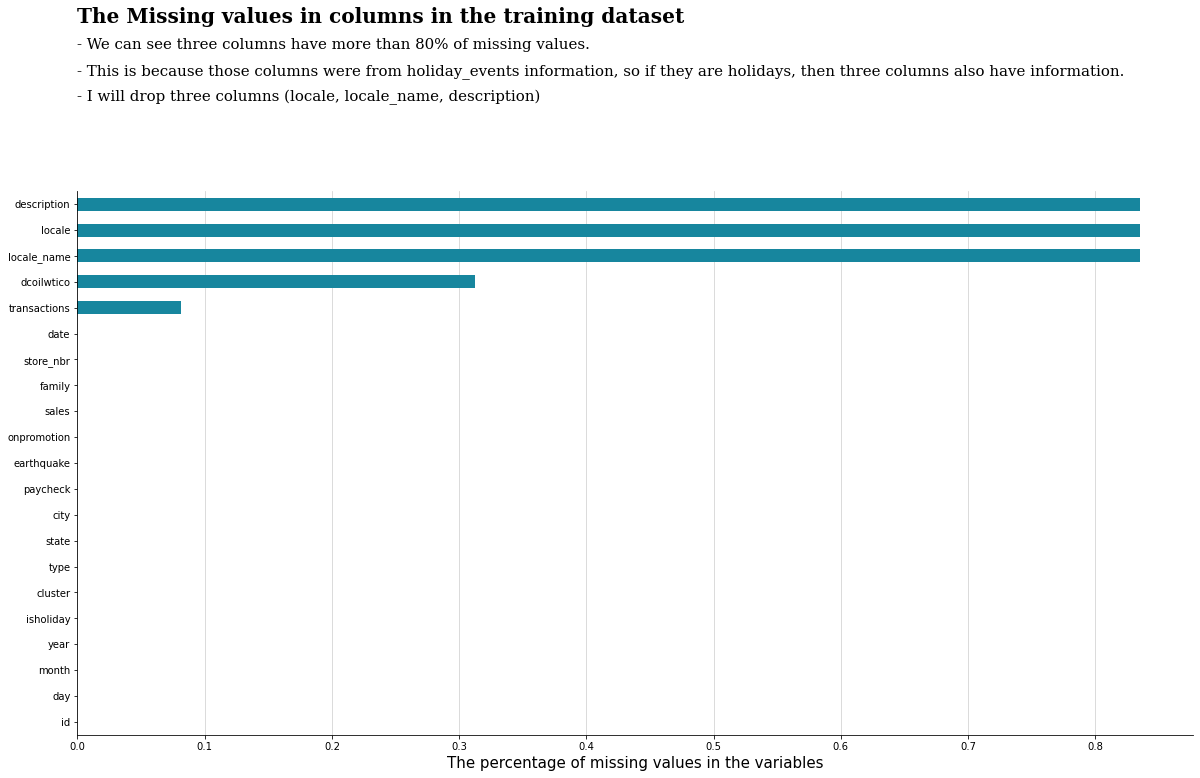

In [35]:
missing_train = (train.isnull().sum()/len(train)).sort_values(ascending=True)
fig, ax = plt.subplots(figsize=(20, 10))
missing_train.plot(kind='barh', color='#17869E')
plt.xlabel('The percentage of missing values in the variables', fontsize=15);

# Observation
plt.text(0, 27, "The Missing values in columns in the training dataset", 
        fontsize=20, fontweight='bold', fontfamily='serif')
plt.text(0, 26, "- We can see three columns have more than 80% of missing values.",
        fontsize=15, fontweight='light', fontfamily='serif')
plt.text(0, 25, "- This is because those columns were from holiday_events information, so if they are holidays, then three columns also have information.",
        fontsize=15, fontweight='light', fontfamily='serif')
plt.text(0, 24, "- I will drop three columns (locale, locale_name, description)",
        fontsize=15, fontweight='light', fontfamily='serif');


# Ax spines
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(False)

ax.set_axisbelow(True)
ax.xaxis.grid(color='lightgray', linestyle='-');

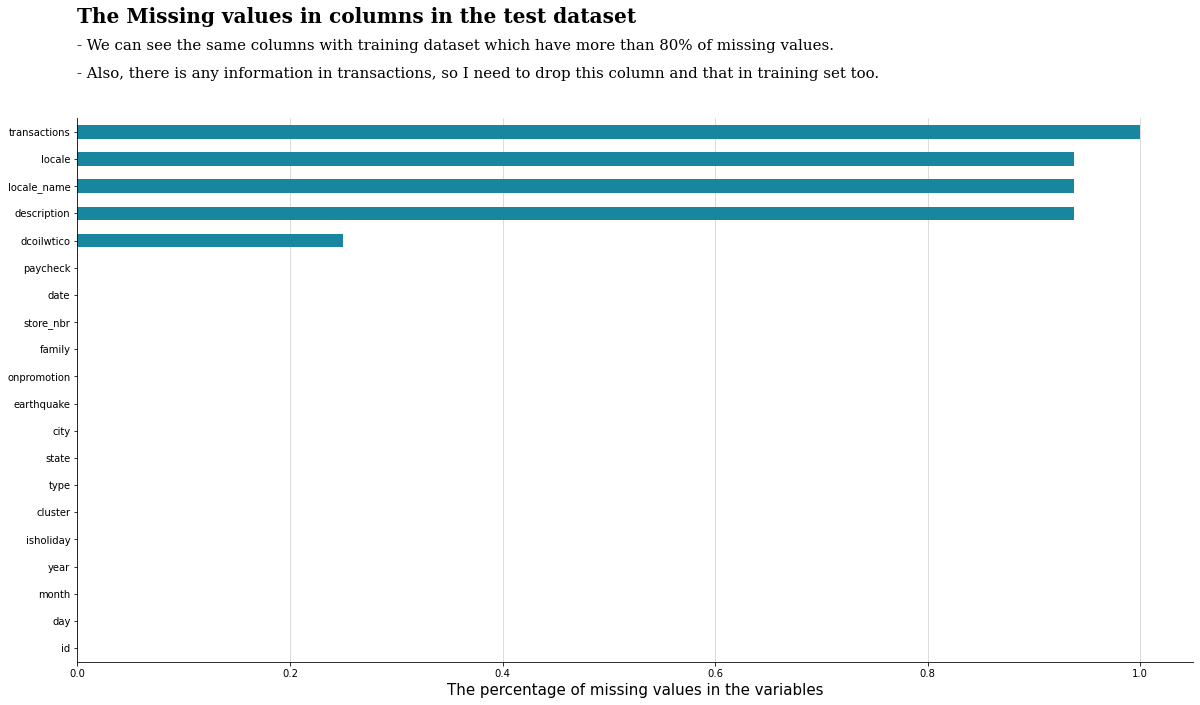

In [36]:
missing_test = (test.isnull().sum()/len(test)).sort_values(ascending=True)
fig, ax = plt.subplots(figsize=(20, 10))
missing_test.plot(kind='barh', color='#17869E')
plt.xlabel('The percentage of missing values in the variables', fontsize=15);

# Observation
plt.text(0, 23, "The Missing values in columns in the test dataset", 
        fontsize=20, fontweight='bold', fontfamily='serif')
plt.text(0, 22, "- We can see the same columns with training dataset which have more than 80% of missing values.",
        fontsize=15, fontweight='light', fontfamily='serif')
plt.text(0, 21, "- Also, there is any information in transactions, so I need to drop this column and that in training set too.",
        fontsize=15, fontweight='light', fontfamily='serif');


# Ax spines
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(False)

ax.set_axisbelow(True)
ax.xaxis.grid(color='lightgray', linestyle='-');

In [37]:
# drop columns that I don't need 
drop_cols = ['transactions', 'locale', 'locale_name', 'description']
train.drop(drop_cols, axis=1, inplace=True)
test.drop(drop_cols, axis=1, inplace=True)

In [38]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,type,cluster,isholiday,year,month,day,paycheck,earthquake
0,0,2013-01-01,1,AUTOMOTIVE,0.00000,0.00000,NaN,Quito,Pichincha,D,13,1,2013,1,1,0.00000,0
1,1,2013-01-01,1,BABY CARE,0.00000,0.00000,NaN,Quito,Pichincha,D,13,1,2013,1,1,0.00000,0
2,2,2013-01-01,1,BEAUTY,0.00000,0.00000,NaN,Quito,Pichincha,D,13,1,2013,1,1,0.00000,0
3,3,2013-01-01,1,BEVERAGES,0.00000,0.00000,NaN,Quito,Pichincha,D,13,1,2013,1,1,0.00000,0
4,4,2013-01-01,1,BOOKS,0.00000,0.00000,NaN,Quito,Pichincha,D,13,1,2013,1,1,0.00000,0


#### Handling with dcoilwtico missing values

For oil information, we have some missing values in __dcoilwtico__ in training and test dataset. I would like to fill NaN by using pandas' interpolate method. 

Before performing imputing missing values, let's see the original dataset. 

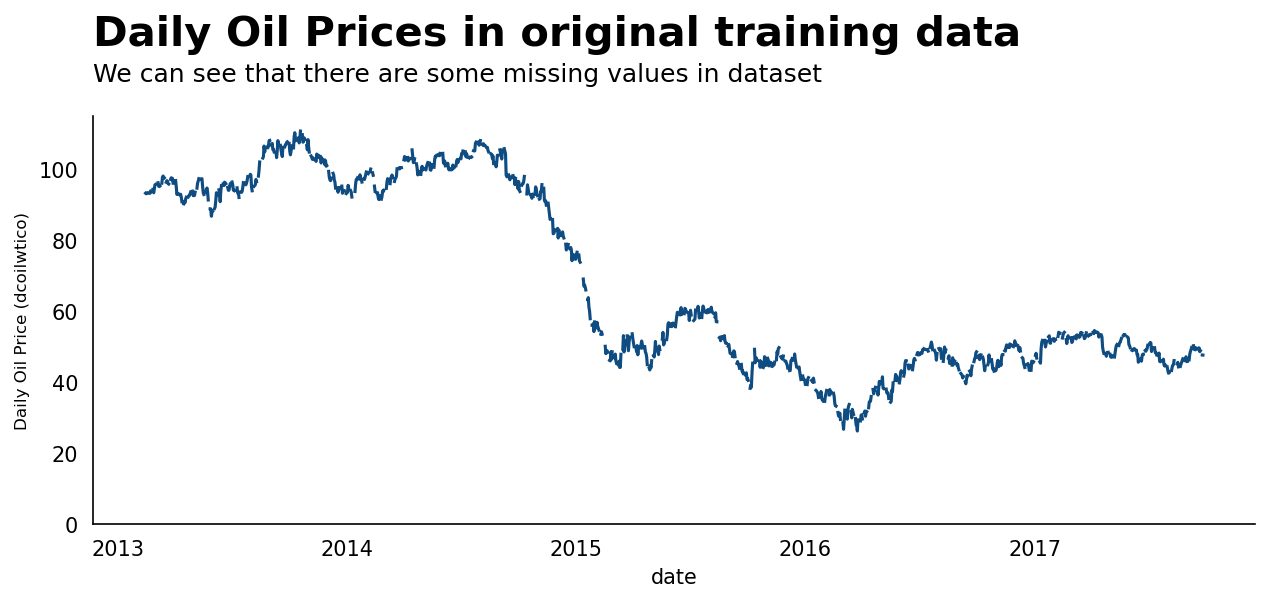

In [39]:
# original training data' dcoilwtico (oil)
fig = plt.figure(figsize=(10,4), dpi=150, facecolor='white')
gs = fig.add_gridspec(1,1)
gs.update(wspace=0, hspace=0)

ax = fig.add_subplot(gs[0,0])
ax.set_facecolor('white')

train.groupby(['date'])['dcoilwtico'].mean().plot(color='#0f4c81', ax=ax)

Xstart, Xend = ax.get_xlim()
Ystart, Yend = ax.get_ylim()

ax.set_ylim([0, Yend])
ax.set_xlim([Xstart, Xend-1])
ax.set_ylabel('Daily Oil Price (dcoilwtico)', fontsize=8)
ax.tick_params(axis='both', which='both', left=False, bottom=False)

plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)

for s in ['right', 'top']:
    ax.spines[s].set_visible(False)
    
ax.text(Xstart, Yend+20, "Daily Oil Prices in original training data", fontsize=20, fontweight='bold')
ax.text(Xstart, Yend+10, "We can see that there are some missing values in dataset", fontsize=12, fontweight='light');

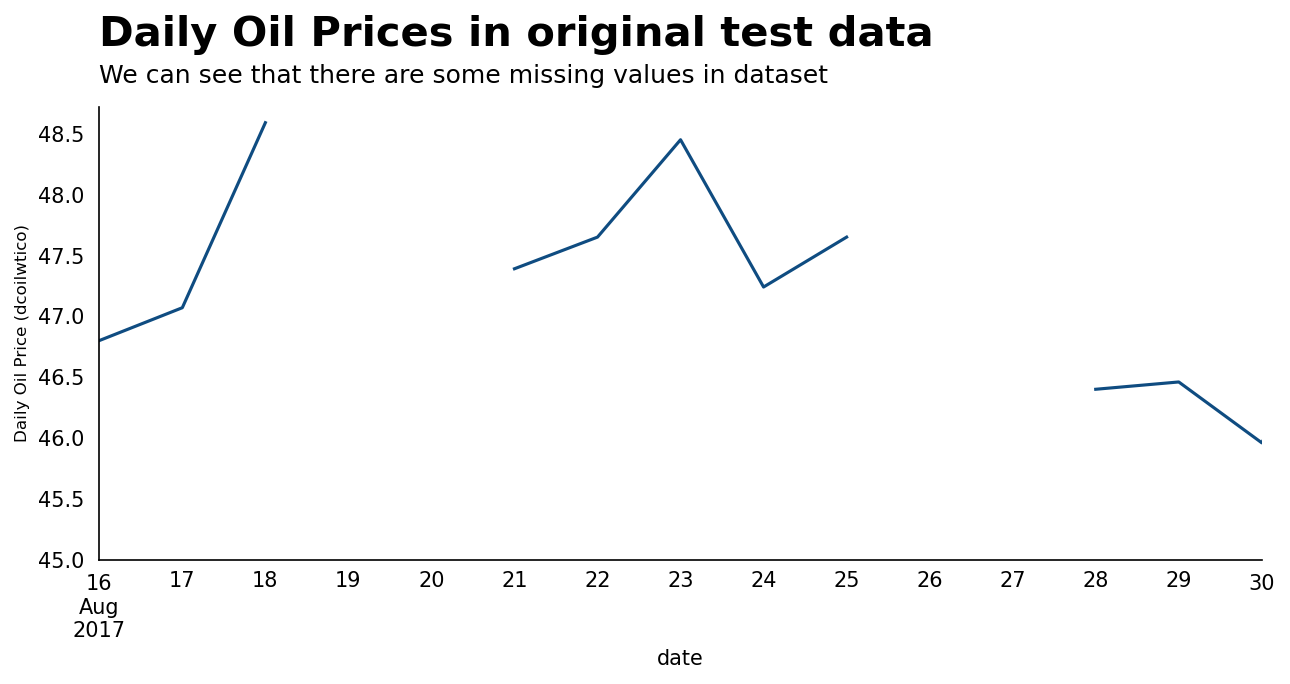

In [40]:
# original test data' dcoilwtico (oil)
fig = plt.figure(figsize=(10,4), dpi=150, facecolor='white')
gs = fig.add_gridspec(1,1)
gs.update(wspace=0, hspace=0)

ax = fig.add_subplot(gs[0,0])
ax.set_facecolor('white')

test.groupby(['date'])['dcoilwtico'].mean().plot(color='#0f4c81', ax=ax)

Xstart, Xend = ax.get_xlim()
Ystart, Yend = ax.get_ylim()

ax.set_ylim([45, Yend])
ax.set_xlim([Xstart, Xend-1])
ax.set_ylabel('Daily Oil Price (dcoilwtico)', fontsize=8)
ax.tick_params(axis='both', which='both', left=False, bottom=False)

plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)

for s in ['right', 'top']:
    ax.spines[s].set_visible(False)
    
ax.text(Xstart, Yend+0.5, "Daily Oil Prices in original test data", fontsize=20, fontweight='bold')
ax.text(Xstart, Yend+0.2, "We can see that there are some missing values in dataset", fontsize=12, fontweight='light');

In [41]:
# 2013-01-01 is the first date in training set, and it doesn't have dcoilwtico infomation. 
# When we use interpolate, it won't fill the first missing values so, 
# I will use the mean (93.05) of 2013-01-02 (93.14) and 2013-01-03 (92.97)'s oil price to fill 2013-01-01 values

train.loc[(train['date']=='2013-01-01'), 'dcoilwtico'] = 93.05

# fill NaN by using interpolate
train['dcoilwtico'] = train['dcoilwtico'].interpolate(method='linear')
test['dcoilwtico'] = test['dcoilwtico'].interpolate(method='linear')

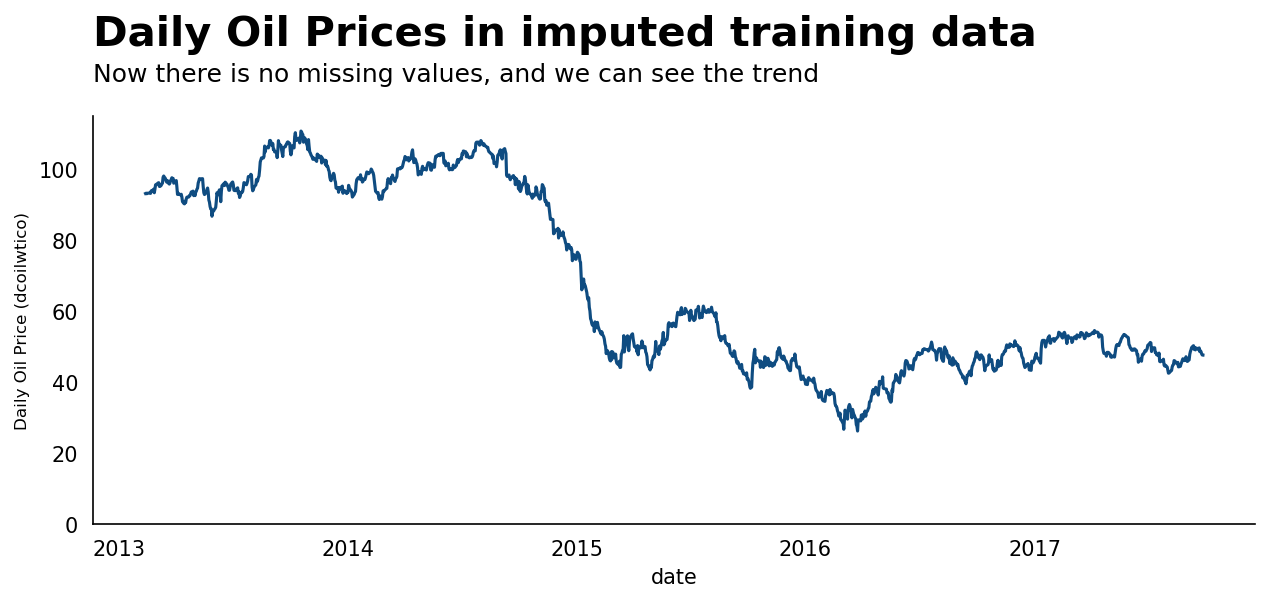

In [42]:
# imputed training data' dcoilwtico (oil)
fig = plt.figure(figsize=(10,4), dpi=150, facecolor='white')
gs = fig.add_gridspec(1,1)
gs.update(wspace=0, hspace=0)

ax = fig.add_subplot(gs[0,0])
ax.set_facecolor('white')

train.groupby(['date'])['dcoilwtico'].mean().plot(color='#0f4c81', ax=ax)

Xstart, Xend = ax.get_xlim()
Ystart, Yend = ax.get_ylim()

ax.set_ylim([0, Yend])
ax.set_xlim([Xstart, Xend-1])
ax.set_ylabel('Daily Oil Price (dcoilwtico)', fontsize=8)
ax.tick_params(axis='both', which='both', left=False, bottom=False)

plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)

for s in ['right', 'top']:
    ax.spines[s].set_visible(False)
    
ax.text(Xstart, Yend+20, "Daily Oil Prices in imputed training data", fontsize=20, fontweight='bold')
ax.text(Xstart, Yend+10, "Now there is no missing values, and we can see the trend", fontsize=12, fontweight='light');

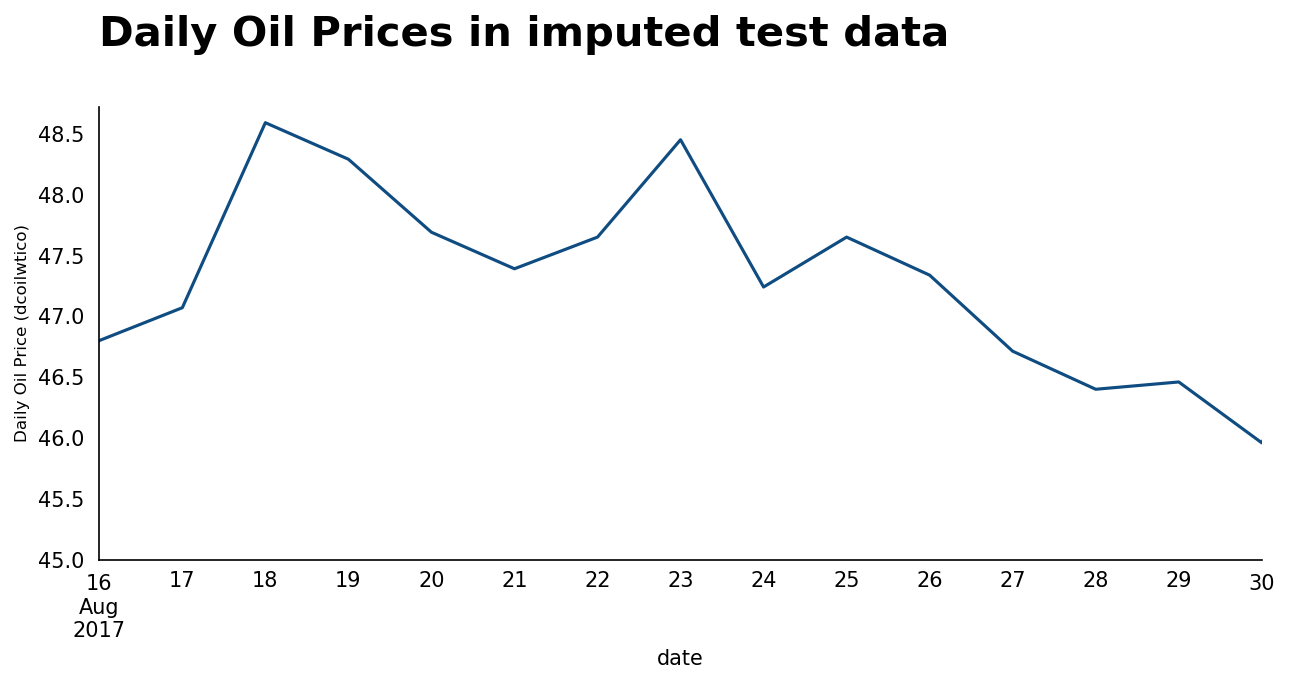

In [43]:
# imputed test data' dcoilwtico (oil)
fig = plt.figure(figsize=(10,4), dpi=150, facecolor='white')
gs = fig.add_gridspec(1,1)
gs.update(wspace=0, hspace=0)

ax = fig.add_subplot(gs[0,0])
ax.set_facecolor('white')

test.groupby(['date'])['dcoilwtico'].mean().plot(color='#0f4c81', ax=ax)

Xstart, Xend = ax.get_xlim()
Ystart, Yend = ax.get_ylim()

ax.set_ylim([45, Yend])
ax.set_xlim([Xstart, Xend-1])
ax.set_ylabel('Daily Oil Price (dcoilwtico)', fontsize=8)
ax.tick_params(axis='both', which='both', left=False, bottom=False)

plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)

for s in ['right', 'top']:
    ax.spines[s].set_visible(False)
    
ax.text(Xstart, Yend+0.5, "Daily Oil Prices in imputed test data", fontsize=20, fontweight='bold');

__Question:__ Can I use interpolate method to fill NaN in test dataset?

Check again if we have missing values in our dataset

In [44]:
train.isnull().sum()/len(train)

id            0.00000
date          0.00000
store_nbr     0.00000
family        0.00000
sales         0.00000
onpromotion   0.00000
dcoilwtico    0.00000
city          0.00000
state         0.00000
type          0.00000
cluster       0.00000
isholiday     0.00000
year          0.00000
month         0.00000
day           0.00000
paycheck      0.00000
earthquake    0.00000
dtype: float64

In [45]:
test.isnull().sum()/len(test)

id            0.00000
date          0.00000
store_nbr     0.00000
family        0.00000
onpromotion   0.00000
dcoilwtico    0.00000
city          0.00000
state         0.00000
type          0.00000
cluster       0.00000
isholiday     0.00000
year          0.00000
month         0.00000
day           0.00000
paycheck      0.00000
earthquake    0.00000
dtype: float64

### Create a Cleaning Function

In [89]:
# Create function for isholiday column

def holiday_id(df):
    if df['holiday_type'] == 'Event': return 1
    elif df['holiday_type'] == 'Additional': return 1
    elif df['holiday_type'] == 'Bridge': return 1
    elif df['holiday_type'] == 'Transfer': return 1
    elif (df['holiday_type'] == 'Holiday') & (df['transferred']==False): return 1
    elif (df['holiday_type'] == 'Holiday') & (df['transferred']==True): return 0
    elif df['holiday_type'] == 'Weekday': return 0
    elif df['holiday_type'] == 'Work Day': return 0
    

# create function to make paycheck column for training set
def day_id(df):
    if (df['2016_feb']==1) & (df['day']==29): return 1
    elif (df['2016_feb']==0) & (df['day']==28): return 1
    elif (df['31th'] == 0) & (df['day']==30): return 1
    elif (df['31th']==1) & (df['day']==31): return 1
    elif (df['day']==15): return 1
    
    
# create a column of paycheck for test.csv
# the code is more simple because test.csv has only data from 2017-08-16 to 2017-08-31

def day_id_test(df):
    if df['day']==31: 
        return 1
    else: 
        return 0
    
    
# create new column for earthquake for training and test dataset
def earthquake_id(df):
    if (df['year'] == 2016) & (df['month']==4) & (df['day']==16): 
        return 1
    else: 
        return 0


In [94]:
def clean_data(df_path):
    """ Perform feature selection, re-encoding, and engineering for store data
    
    INPUT:
        df_path - path for data
    OUTPUT:
        train - cleaned train dataframe
        test - cleaned test dataframe
    """
    
    # load data (we don't use transaction.csv at all, so here I remove it)
    file_names = ['holidays_events', 'oil', 'stores', 'train', 'test', 'sample_submission']
    table = [pd.read_csv(df_path/f'{fname}.csv') for fname in file_names]
    holidays, oil, stores, train, test, s_submission = table
    print("Original Training dataset: ", train.shape)
    print("Original Test dataset: ", test.shape)
    
    # Change the name of type in holidays because train has the same name of column 
    holidays.rename(columns={'type': 'holiday_type'}, inplace=True)
    
    # merging tables
    train = train.merge(holidays, how='left', on='date')
    train = train.merge(oil, how='left', on='date')
    train = train.merge(stores, how='left', on='store_nbr')
    
    test = test.merge(holidays, how='left', on='date')
    test = test.merge(oil, how='left', on='date')
    test = test.merge(stores, how='left', on='store_nbr')
    
    print("\nAfter merge, Training dataset: ", train.shape)
    print("After merge, Test dataset: ", test.shape)
    
    
    # Feature engineering for holidays
    # 1) Create isholiday column based on holidays_events information
    ## (1) fill NaN values in holiday_type with Weekday
    train['holiday_type'] = train['holiday_type'].fillna('Weekday')
    test['holiday_type'] = test['holiday_type'].fillna('Weekday')
    
    ## (2) use holiday_id function to create new column in train and test set
    train['isholiday'] = train.apply(holiday_id, axis=1)
    test['isholiday'] = test.apply(holiday_id, axis=1)
    
    ## (3) drop holiday_type and transferred columns from training and test dataset
    train.drop(['holiday_type', 'transferred'], axis=1, inplace=True)
    test.drop(['holiday_type', 'transferred'], axis=1, inplace=True)
    
    
    # 2) Create a column for paychecks
    ## (1) change dtype of date to datetime64
    train['date'] = train['date'].astype('datetime64')
    test['date'] = test['date'].astype('datetime64')
    
    ## (2) create columns for year, month, day based on date column
    train['year'] = train['date'].dt.year
    train['month'] = train['date'].dt.month
    train['day'] = train['date'].dt.day

    test['year'] = test['date'].dt.year
    test['month'] = test['date'].dt.month
    test['day'] = test['date'].dt.day
    
    ## (3) create a new column for 31th which indicates whether the month has 31th day or not
    train.loc[train['month'].isin([4, 6, 9, 11]), '31th'] = 0
    train.loc[train['month'].isin([1, 3, 5, 7, 8, 10, 12]), '31th'] = 1
    train.loc[train['month'].isin([2]), '31th'] = 2
 
    ## (4) create a new column for 2016_feb which indicates whether 2016 year or not
    # because 2016's Feb has 29th, so the last day of the month is 29th not 28th
    train.loc[train['year'].isin([2016]), '2016_feb'] = 1
    train.loc[train['year'].isin([2013, 2014, 2015, 2017]), '2016_feb'] = 0

    ## (5) use day_id function to create new column for paycheck
    train['paycheck'] = train.apply(day_id, axis=1)
    train['paycheck'] = train['paycheck'].fillna(0)
    
    ## (6) use day_id_test function to create new column for paycheck in testset
    test['paycheck'] = test.apply(day_id_test, axis=1)
    test['paycheck'] = test['paycheck'].fillna(0)
    
    
    # 3) Create a column for earthquake
    ## use earthquack_id function to create new column for training and test dataset
    train['earthquake'] = train.apply(earthquake_id, axis=1)
    test['earthquake'] = test.apply(earthquake_id, axis=1)

    # drop 31th and 2016_feb that we don't need anymore
    train.drop(['31th', '2016_feb'], axis=1, inplace=True)
    
    
    # Handling missing values
    ## (1) drop columns that I don't need
    drop_cols = ['locale', 'locale_name', 'description']
    train.drop(drop_cols, axis=1, inplace=True)
    test.drop(drop_cols, axis=1, inplace=True)
    
    
    ## (2) fill NaN by using pd.interpolate
    # 2013-01-01 is the first date in training set, and it doesn't have dcoilwtico infomation. 
    # When we use interpolate, it won't fill the first missing values so, 
    # I will use the mean (93.05) of 2013-01-02 (93.14) and 2013-01-03 (92.97)'s oil price to fill 2013-01-01 values

    train.loc[(train['date']=='2013-01-01'), 'dcoilwtico'] = 93.05

    # fill NaN by using interpolate
    train['dcoilwtico'] = train['dcoilwtico'].interpolate(method='linear')
    test['dcoilwtico'] = test['dcoilwtico'].interpolate(method='linear')
    
    print("\nFinal Training dataset: ", train.shape)
    print("Final Test dataset: ", test.shape)
    
    return train, test

In [95]:
df_path = Path('/Users/yejiseoung/Dropbox/My Mac (Yejis-MacBook-Pro.local)/Documents/Projects/Store_Time_Series_Forecasting/Data')

In [96]:
df_train, df_test = clean_data(df_path)

Original Training dataset:  (3000888, 6)
Original Test dataset:  (28512, 5)

After merge, Training dataset:  (3054348, 16)
After merge, Test dataset:  (28512, 15)

Final Training dataset:  (3054348, 17)
Final Test dataset:  (28512, 16)


In [98]:
df_train.head()

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,type,cluster,isholiday,year,month,day,paycheck,earthquake
0,0,2013-01-01,1,AUTOMOTIVE,0.00000,0.00000,93.05000,Quito,Pichincha,D,13,1,2013,1,1,0.00000,0
1,1,2013-01-01,1,BABY CARE,0.00000,0.00000,93.05000,Quito,Pichincha,D,13,1,2013,1,1,0.00000,0
2,2,2013-01-01,1,BEAUTY,0.00000,0.00000,93.05000,Quito,Pichincha,D,13,1,2013,1,1,0.00000,0
3,3,2013-01-01,1,BEVERAGES,0.00000,0.00000,93.05000,Quito,Pichincha,D,13,1,2013,1,1,0.00000,0
4,4,2013-01-01,1,BOOKS,0.00000,0.00000,93.05000,Quito,Pichincha,D,13,1,2013,1,1,0.00000,0


### Exploratory Data Analysis

#### Univariate analysis

In [46]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,type,cluster,isholiday,year,month,day,paycheck,earthquake
0,0,2013-01-01,1,AUTOMOTIVE,0.00000,0.00000,93.05000,Quito,Pichincha,D,13,1,2013,1,1,0.00000,0
1,1,2013-01-01,1,BABY CARE,0.00000,0.00000,93.05000,Quito,Pichincha,D,13,1,2013,1,1,0.00000,0
2,2,2013-01-01,1,BEAUTY,0.00000,0.00000,93.05000,Quito,Pichincha,D,13,1,2013,1,1,0.00000,0
3,3,2013-01-01,1,BEVERAGES,0.00000,0.00000,93.05000,Quito,Pichincha,D,13,1,2013,1,1,0.00000,0
4,4,2013-01-01,1,BOOKS,0.00000,0.00000,93.05000,Quito,Pichincha,D,13,1,2013,1,1,0.00000,0


In [78]:
train['city'].nunique()

22

In [77]:
train['state'].nunique()

16

In [47]:
train.shape, test.shape

((3054348, 17), (28512, 16))

In [72]:
background_color = 'white'
other = '#144082'
COLOR = '#323232'
plt.rcParams['text.color'] = '#323232'
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams["font.family"] = "sansserif"
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

findfont: Font family ['sansserif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sansserif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sansserif'] not found. Falling back to DejaVu Sans.


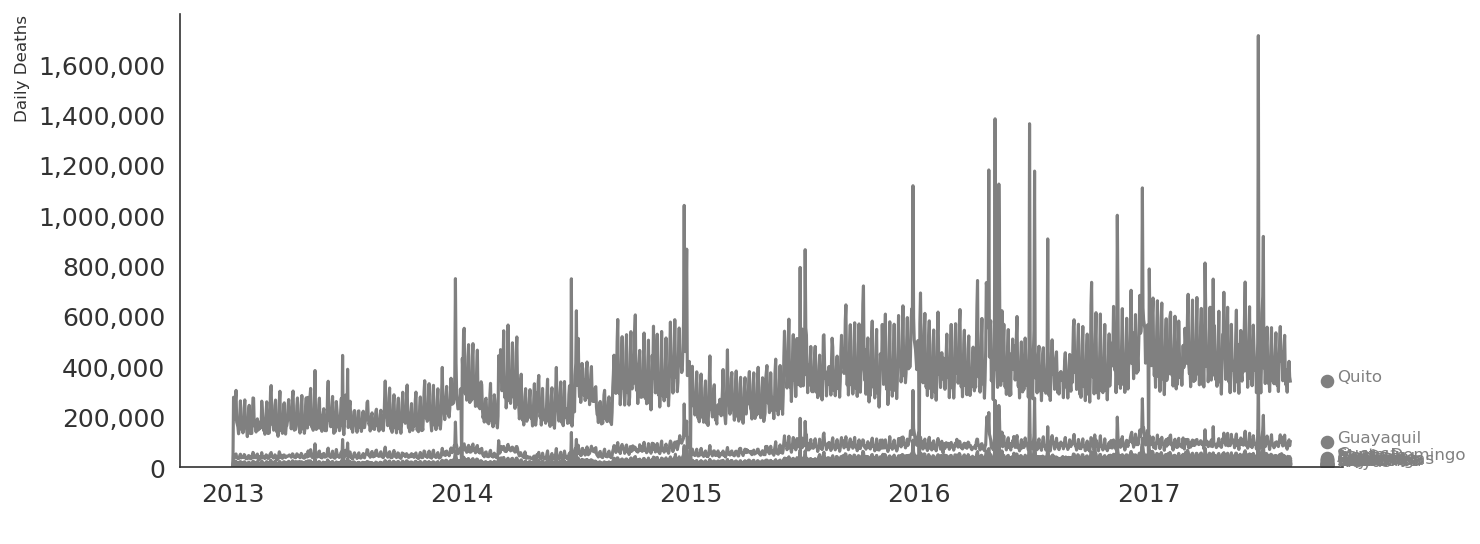

In [73]:
background_color='white'
temp_daily = train.groupby(['date', 'city'])['sales'].sum().unstack()

fig = plt.figure(figsize=(10, 4), dpi=150,facecolor=background_color)
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0, hspace=0)
ax0 = fig.add_subplot(gs[0, 0])
ax0.set_facecolor(background_color)

for i in temp_daily.columns:
    sns.lineplot(x='date',y=i,data=temp_daily,color='gray',ax=ax0)
#sns.lineplot(x='date',y='Europe',data=temp_daily,color='#0f4c81',ax=ax0)


Xstart, Xend = ax0.get_xlim()
Ystart, Yend = ax0.get_ylim()

ax0.set_ylim([0,Yend])
ax0.set_xlim(Xstart,Xend-1)
ax0.set_ylabel("Daily Deaths",fontsize=8,loc='top')
ax0.set_xlabel(" ",fontsize=8,loc='left')
ax0.tick_params(axis = "both", which = "both", left=False, bottom=False)

plt.setp(ax0.xaxis.get_majorticklabels(), rotation = 0)
locator = mdates.AutoDateLocator(minticks=3, maxticks=12)
formatter = mdates.ConciseDateFormatter(locator)
ax0.xaxis.set_major_locator(locator)
ax0.xaxis.set_major_formatter(formatter)
ax0.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

for s in ["right", "top"]:
    ax0.spines[s].set_visible(False)

for s in ["left","bottom"]:
    ax0.spines[s].set_color(COLOR)
    

for i in temp_daily.columns:
    ax0.plot(Xend-25,temp_daily[i][-1], 'ko', markersize=5, fillstyle='full',color='gray', markeredgewidth=1.5)
    ax0.text(Xend-10,temp_daily[i][-1],i,color='gray',fontweight='light',fontsize=8, rotation=0)

In [53]:
a = train.groupby(['date', 'city'])['sales'].sum().unstack()

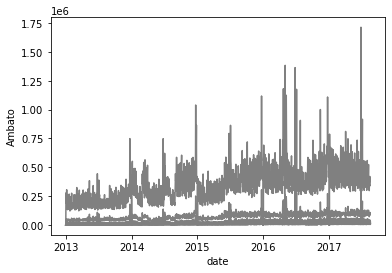

In [64]:
for i in a.columns:
    sns.lineplot(x='date', y=i, data=a, color='gray')